In [1]:
cd ..

C:\Users\giaco\sbp-abm\municipalities_abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from municipalities_abm.model import SBPAdoption

from municipalities_abm.custom_transformers import (
    TransformCensusFeaturesClsf,
    TransformCensusFeaturesRegr,
    TransformClimateFeatures,
    TransformSoilFeatures,
    )

%matplotlib inline

In [3]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm")

In [4]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
np.set_printoptions(precision=6)

In [5]:
# Where to save the figures
PROJECT_ROOT_DIR = "model_validation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [6]:
path_to_adoption_port_real = "./model_validation/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)

In [7]:
path_to_adoption_munic_real = "./model_validation/data/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

# Model initialization and step

In [8]:
start_year = 1996

In [9]:
# Note that the model can be initialized with a seed to have reproducible results
model = SBPAdoption(initial_year=start_year)

In [10]:
stop_year = 2019

for i in range(start_year, stop_year):
    model.step()
    print("Step", str(i))

Step 1996
Step 1997
Step 1998
Step 1999
Step 2000
Step 2001
Step 2002
Step 2003
Step 2004
Step 2005
Step 2006
Step 2007
Step 2008
Step 2009
Step 2010
Step 2011
Step 2012
Step 2013
Step 2014
Step 2015
Step 2016
Step 2017
Step 2018


# Data collection

In [11]:
def collect_agent_level_yearly_adoption(abm_model):
    """
    Function to collect data at the individual agent level
    
    Returns
    -------
    municipalities_adoption : pd DataFrame
        Multiindex DataFrame reporting for each muninicipality and for each year the ratio of SBP adopted
    """
    municipality_agents = abm_model.schedule.agents
    municipalities = [munic.Municipality for munic in municipality_agents]
    
    # Create the empty df
    years = np.arange(start_year, stop_year)
    municipalities_adoption = pd.MultiIndex.from_product([municipalities, years])
    municipalities_adoption = municipalities_adoption.to_frame()
    municipalities_adoption.drop(municipalities_adoption.columns, axis=1, inplace=True)
    municipalities_adoption.index.rename(['Municipality', 'Year'], inplace=True)
    municipalities_adoption['predicted_adoption'] = None
    
    # Create a dictionary mapping to each municipality name the Series of its adoption in each year
    yearly_adoptions = [munic.yearly_adoption for munic in municipality_agents]
    map_dict = dict(zip(municipalities, yearly_adoptions))
    for k, v in map_dict.items():
        map_dict[k] = pd.Series(v)
        map_dict[k].name = 'predicted_adoption' # Necessary to use .udpdate() method

    # For each municipality, updates the values of adoption    
    for munic in municipalities:
        df = municipalities_adoption.loc[munic]
        df.update(map_dict[munic])
        municipalities_adoption.loc[munic] = df.values
        
    return municipalities_adoption

In [12]:
munic_yearly_adoption = collect_agent_level_yearly_adoption(model)

In [13]:
aggr_adoption_out = model.datacollector.get_model_vars_dataframe()
aggr_adoption_out.set_index('Year', inplace=True)

In [14]:
yearly_adoption_portugal_pred = aggr_adoption_out['Area sown in the last year [ha/y]']

# Model validation

## Macro-validation

### Qualitative

In [15]:
def plot_adoption_trend(predicted_adoption, real_adoption, max_y, fig_title):
    """
    Function to plot two adoptions, the predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(9, 4)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Hectares", fontsize=16)
    ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    ax_pr.plot(real_adoption.index, real_adoption.values, 'b:', linewidth=1, label='Observed adoption')
    ax_pr.plot(predicted_adoption.index, predicted_adoption.values, 'r--', linewidth=1, label='Predicted adoption')
    ax_pr.legend(loc='best')

    save_fig((fig_title))    

#### Plot predicted vs real adoption in Portugal

Saving figure Yearly SBP adoption in Portugal


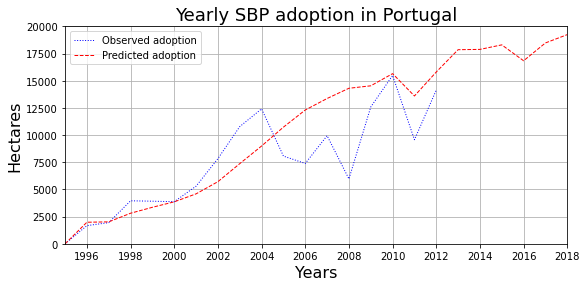

In [16]:
plot_adoption_trend(yearly_adoption_portugal_pred, yearly_adoption_portugal_real, 20000, "Yearly SBP adoption in Portugal")

#### Plot predicted vs real cumulative adoption in Portugal

In [17]:
cumulative_adoption_portugal_pred = aggr_adoption_out['Total area of SBP sown [ha]']
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

Saving figure Cumulative SBP adoption in Portugal


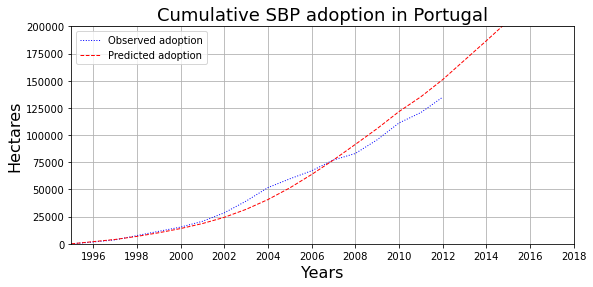

In [18]:
plot_adoption_trend(cumulative_adoption_portugal_pred, cumulative_adoption_portugal_real, 200000, "Cumulative SBP adoption in Portugal")

## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012, or the ending years of the simulation if it is before 2012.

(Note that for validation purposes the years will always been between 1996 and 2012, unless we want the error only on PCF project years)

### Quantitative

In [19]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real['adoption_in_year'], munic_yearly_adoption],
                                      axis=1, join='inner')
final_year_val = min(2012, stop_year)
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) >= final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [20]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

def micro_validation(adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    pred = adoption_rp['predicted_adoption'].values
    
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / real.std()
    #r2 = r2_score(real, pred)
    #adj_r2 = adjusted_r2(r2_scores, (num_test_points // folds), num_features)
    print("Total RMSE:", str(rmse))
    print("Total relative RMSE:", str(rrmse))
    #print("Total R2 score:", str(r2))
    
    get_yearly_and_cumul_rmse(adoption_rp)

Total RMSE: 0.00926638226022909
Total relative RMSE: 0.9989923436259894


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011
RMSE on year,0.004525,0.004188,0.003802,0.004826,0.005196,0.005159,0.007010,0.007701,0.008736,0.011371,0.006544,0.012935,0.009394,0.011422,0.018470,0.012666
Relative RMSE on year,0.941597,0.965766,0.999441,0.967027,0.979699,1.006425,0.927657,1.095215,1.028425,1.048591,1.351955,1.081217,1.361999,1.018035,0.917577,1.035471
RMSE till year,0.004525,0.004360,0.004182,0.004352,0.004534,0.004644,0.005050,0.005452,0.005908,0.006659,0.006649,0.007380,0.007554,0.007893,0.008994,0.009266
Relative RMSE till year,0.941597,0.952495,0.961270,0.962623,0.965663,0.970219,0.951787,0.961976,0.963070,0.979775,1.000532,1.007509,1.034364,1.031859,0.994505,0.998992


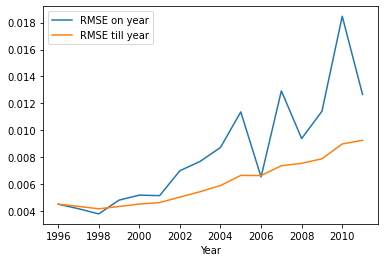

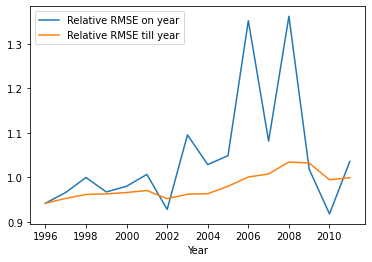

In [22]:
micro_validation(munic_adoption_real_pred)

### Qualitative

#### Ditribution of adoption in each year in each municipality

<AxesSubplot:ylabel='Frequency'>

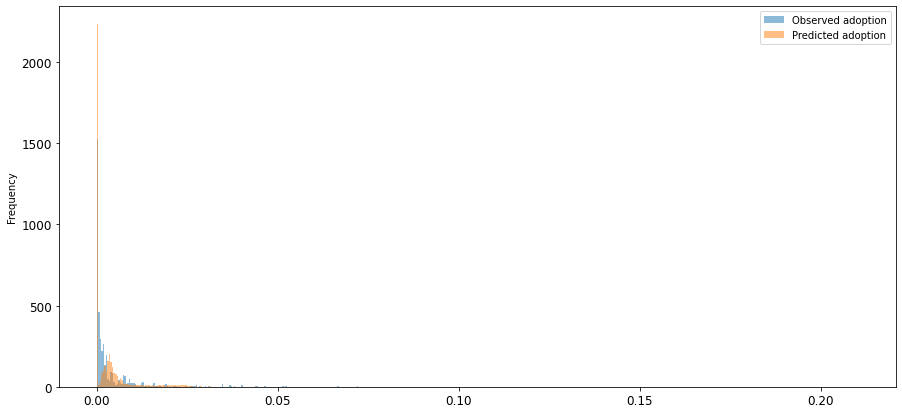

In [23]:
munic_adoption_real_pred.rename(columns={"adoption_in_year": "Observed adoption", "predicted_adoption": "Predicted adoption"},
                                inplace=True)
munic_adoption_real_pred.plot.hist(figsize=(15, 7), bins=500, alpha=0.5, 
                                   xlabel="Fraction of pastures area switched to SBP in one year", fontsize=12)

#### Map based on adoption level for each municipality at the end of the simulation

In [24]:
import geopandas as gpd

In [25]:
def collect_agent_level_for_map(abm_model, year):
    """
    Function to collect cumulative adoption in a certain year (in ha and in fraction over pastures area)
    and the shape of the municialities in order to plot the map.
    
    Returns
    -------
    munic_cumul_adoption_and_shape : pd DataFrame
        DataFrame reporting for each muninicipality the total cumulative adoption in ha and its shape
    """
    municipality_agents = abm_model.schedule.agents
    #municipalities = [munic.Municipality for munic in municipality_agents]
    
    #munic_cumul_adoption_and_shape = pd.DataFrame(index=municipalities)
    munic_cumul_adoption_and_shape = gpd.GeoDataFrame()
    munic_cumul_adoption_and_shape['Total cumulative adoption in ' + str(year) + ' [ha]'] = None
    munic_cumul_adoption_and_shape['Total cumulative adoption in ' + str(year) + ' [fraction]'] = None
    munic_cumul_adoption_and_shape['geometry'] = None
    
    for munic in municipality_agents:
        yearly_adoption_until_year_ha = [v for k, v in munic.yearly_adoption_ha.items()
                                        if k <= year]
        munic_tot_cumul_adoption_year_ha = sum(yearly_adoption_until_year_ha)
        
        yearly_adoption_until_year = [v for k, v in munic.yearly_adoption.items()
                                     if k <= year]
        munic_tot_cumul_adoption_year = sum(yearly_adoption_until_year)
        
        munic_cumul_adoption_and_shape.loc[munic.Municipality] = (
            munic_tot_cumul_adoption_year_ha, 
            munic_tot_cumul_adoption_year,
            munic.shape
        )
    
    return munic_cumul_adoption_and_shape

In [26]:
year_for_map = 2012

In [27]:
type(munic_yearly_adoption_real.index.get_level_values(1)[0])

numpy.int64

In [28]:
pred_for_map = collect_agent_level_for_map(model, year_for_map)

In [29]:
geometry = pred_for_map['geometry']
munic_map_adoption_real = munic_yearly_adoption_real.loc[munic_yearly_adoption_real.index.get_level_values(1) == 2012]
munic_map_adoption_real.index = munic_map_adoption_real.index.droplevel(1)

real_for_map = pd.concat([munic_map_adoption_real['tot_cumul_adoption_until_year_ha'], geometry], axis=1)
real_for_map = gpd.GeoDataFrame(real_for_map)

Plot of area adopted in hectares

In [30]:
# Limits for colour scale
sc_min = 0
sc_max = max(pred_for_map['Total cumulative adoption in ' + str(year_for_map) + ' [ha]'])

<AxesSubplot:>

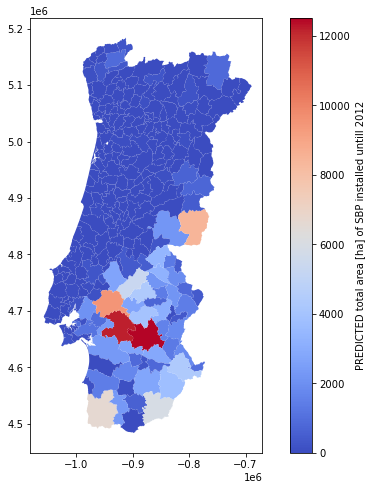

In [31]:
# For other options for plotting with geopandas see https://geopandas.org/mapping.html
pred_for_map.plot(figsize=(10, 8), column=('Total cumulative adoption in ' + str(year_for_map) + ' [ha]'), cmap='coolwarm',
                  legend=True, vmin=sc_min, vmax=sc_max,
                  legend_kwds={'label': ("PREDICTED total area [ha] of SBP installed untill " + str(year_for_map))})

<AxesSubplot:>

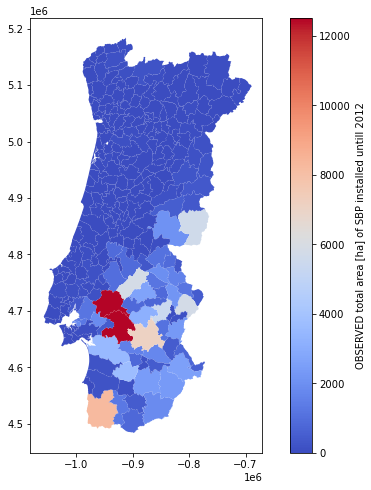

In [32]:
real_for_map.plot(figsize=(10, 8), column=('tot_cumul_adoption_until_year_ha'), cmap='coolwarm',
                  legend=True, vmin=sc_min, vmax=sc_max,
                  legend_kwds={'label': ("OBSERVED total area [ha] of SBP installed untill " + str(year_for_map))})

Plot of fraction of pastures area adopted (Not for validation since not compared with real one)

<AxesSubplot:>

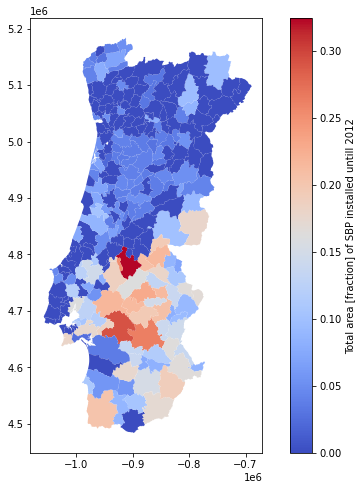

In [33]:
pred_for_map.plot(figsize=(10, 8), column=('Total cumulative adoption in ' + str(year_for_map) + ' [fraction]'),
                  cmap='coolwarm', legend=True,
                  legend_kwds={'label': ("Total area [fraction] of SBP installed untill " + str(year_for_map))})